# Clustering Subreddit Communities

The purpose of this project is to use Spectral Clustering with the Graph Laplacion [1][2] to understand user behavior on Reddit. The idea behind this project is to uncover hidden community structures via user interactions on various Subreddits, and develop heuristics that model likelihood of visiting various pages. The work in this project can be used to build recommendation systems built on top of Bayesian probabilities and simple machine learning models.

The results are fairly promising, and we will discuss the results, implications, and areas of improvement at the end.

The dataset was found on Kaggle at [this link](https://www.kaggle.com/datasets/colemaclean/subreddit-interactions/data). Once you have the data downloaded, we can start our analysis!

## Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import os
import gc

In [51]:
interactions = pd.read_csv('reddit_data.csv').iloc[:, :-1]  # remove utc times as it is irrelevant to our analysis
interactions.tail()

,username,subreddit
13999995,RushNY,iOSthemes
13999996,RushNY,iOSthemes
13999997,RushNY,cars
13999998,RushNY,Toyota
13999999,RushNY,jailbreak


The data has three columns, but we only need the first two ('username' and 'subreddit'). Each row of the data represents a user commenting on a specific subreddit, which we will use as an engagement metric.

## Preprocessing the Data

Now that we have our data loaded in, we need somehow standardize user interactions so that one user does not have greater influence than another user. The approach outlined in the code below groups the interactions by username and finds the proportion of visits made by a user on specific subreddits. Here's the mathematical formulation of this problem:

Given a dataset of interactions where each interaction is defined by a 'username' and a 'subreddit', we want to compute the probability of a user interacting with a specific subreddit. 

$$
p(u, s) = \frac{\sum_{i=1}^{n} r(u_i = u, s_i = s)}{\sum_{i=1}^{n} r(u_i = u)}
$$

Here, $ n $ is the total number of interactions, $ u_i $ is the $ i $-th username, $ s_i $ is the $ i $-th subreddit in the dataset, and $r$ is the indicator function.

In [2]:
subreddit_counts = interactions.groupby(['username', 'subreddit']).size().reset_index(name='subreddit_count')
total_counts = interactions.groupby('username').size().reset_index(name='total_count')
merged_df = pd.merge(subreddit_counts, total_counts, on='username')
merged_df['probabilities'] = merged_df['subreddit_count'] / merged_df['total_count']
interactions = pd.merge(interactions, merged_df[['username', 'subreddit', 'probabilities']], on=['username', 'subreddit'], how='left').values

del subreddit_counts, total_counts, merged_df

interactions = np.vstack(tuple(set(map(tuple,interactions))))  # removing duplicate interactions
display(interactions[-5:])

array([['LaserDinoSquid', 'Erie', '0.006172839506172839'],
       ['sudo-is-my-name', 'techsupportmacgyver', '0.003'],
       ['No_Dana_Only_Zuul', 'PokemonGoUK', '0.003'],
       ['Moonstrucken', 'Random_Acts_Of_Amazon', '0.8034447821681864'],
       ['overnightgamer', 'nintendo', '0.001002004008016032']],
      dtype='<U32')

Now we have converted interactions into a numpy array and added a third columns with the interaction proportions by user. The data now only contains unique rows because we do not need to model redundant edges in our matrix. With this, we can create some maps that will help construct our adjacency matrix and reduce the computational complexity for algorithms later in this project.

In [3]:
nodes = np.unique(interactions[:, 1])
nodes_map = {node: i for i, node in enumerate(nodes)}
reverse_map = {i: node for i, node in enumerate(nodes)}
print("Number of Subreddit pages:", nodes.shape[0])

Number of Subreddit pages: 34967


## Constructing Adjacency/Degree/Graph Laplacion Matrices

With our data set up and ready to go, we can begin constructing a weighted Adjacency Matrix. In our case, let $A$ be an adjacency matrix where $A_{i, j}$ represents the weighted connection between node $i$ and node $j$. Nodes are mapped from pages using a mapping function $\text{nodes\_map}$ such that $i = \text{nodes\_map}(\text{page1})$ and $j = \text{nodes\_map}(\text{page2})$.

For each user $u$, let  $P_u$  be the set of pages visited by $u$, and let $p_1$ and $p_2$ be any two pages in $P_u$. Define the class probabilities associated with $p_1$ and $p_2$ as $c(p_1)$ and $c(p_2)$, respectively.

***The Adjacency Matrix $A$ is defined as follows [2]:***
$$
A_{i, j} = \sum_{u \in U} \sum_{\substack{p_1, p_2 \in P_u \ p_1 \neq p_2}} c(p_1) \cdot c(p_2)
$$

Where:
- $U$ is the set of all unique users.
- $P_u$ is the set of pages visited by user $u$.
- $c(p_1)$ and $c(p_2)$ are the class probabilities for pages $p_1$ and $p_2$, respectively.
- $i = \text{nodes\_map}(p_1)$ and $j = \text{nodes\_map}(p_2)$.
- $A_{i, j}$  is incremented by the product of the class probabilities $c(p_1) \cdot c(p_2)$.

With $A$ defined, we must then remove any disconnected edges.

Define a mask vector $\mathbf{m}$ of length $n$ such that:

$$
\mathbf{m}_i =
\begin{cases}
1 & \text{if } \sum_{j=1}^{n} A_{i, j} \neq 0 \
0 & \text{if } \sum_{j=1}^{n} A_{i, j} = 0
\end{cases}
$$

Here, $\mathbf{m}_i$ is $1$ if node $i$ has at least one connection, and $0$ if it has no connections.

The reduced adjacency matrix $A{\prime}$ is obtained by selecting only the rows and columns where $\mathbf{m}[i] = 1$:

$$
A’ = A[\mathbf{m} = 1, \mathbf{m} = 1]
$$

***The Degree Matrix $D$ is defined as follows [2]:***

Given a reduced adjacency matrix $A{\prime}$ (obtained from the original adjacency matrix $A$ after removing isolated nodes), the normalized diagonal degree matrix $D$ is defined as:

$$
D = \text{diag}\left(\frac{1}{\sqrt{\sum_{j=1}^{m} A’_{i,j}}}\right)
$$

***The Graph Laplacian Matrix $L$ is defined as follows [1]:***

Via the normalized cuts method [1], the Graph Laplacian can be defined as:

$$
L = D \times A \times D
$$

To make the matrix symmetrical we can simply do:

$$
L = L + L^T
$$

***Computing top $k$ eigenvectors***

Given the eigenvalue decomposition for $L$:

$$
Lx_i = \lambda_i x_i
$$

Where:

- $L$ is symmetric.
- $\lambda_i$ are the eigenvalues, ordered such that $ \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_n $.
- $x_i$ are the corresponding eigenvectors.

The top $k$ eigenvectors then become:

$$
X_k = [x_{(1)}, x_{(2)}, \dots, x_{(k)}]
$$

### Implementing the Algorithm

In [4]:
A = np.zeros(shape=(nodes.shape[0], nodes.shape[0]), dtype=np.float32)

for u in tqdm(np.unique(interactions[:, 0])):
    users = interactions[interactions[:, 0] == u, 1:]
    
    for ind, page1 in enumerate(users[:-1]):
        i = nodes_map[page1[0]]
        for page2 in users[ind:]:
            j = nodes_map[page2[0]]
            if page1[0] != page2[0]:
                A[i, j] += page1[1].astype(np.float32) * page2[1].astype(np.float32)

A = A + A.T

mask = np.sum(A, axis=1) != 0
A = A[mask][:, mask]

D = np.diag(1/np.sqrt(np.sum(A, axis=1)))

L = D @ A @ D  # Graph Laplacian via Normalized Cuts method [1]
v, x = np.linalg.eigh(L)

  0%|          | 0/22610 [00:00<?, ?it/s]

In [5]:
print(f"A.shape: {A.shape}")
print(f"D.shape: {D.shape}")
print(f"L.shape: {L.shape}")
print(f"x.shape: {x.shape}")

A.shape: (34947, 34947)
D.shape: (34947, 34947)
L.shape: (34947, 34947)
x.shape: (34947, 34947)


Since the computation of the eigenvalue decomposition is extremely time-consuming, we can save the eigenvalue decomposition matrix with the code below.

In [6]:
eigs = os.path.join(os.getcwd(), f'GL_Eigenvectors_Weighted')
os.makedirs(eigs, exist_ok=True)
np.save(os.path.join(eigs, 'eigenvectors_x.npy'), x)

## K-Means Algorithm

With our eigenvectors matrix computed, we can apply the k-means algorithm on this new dataset. Because of the nature of the Graph Laplacian, the data will naturally separate at weak edges, which creates local communities in the data.

The k-means algorithm aims to solve [2]:

Given $m$ data points $x^i \in \mathbb{R}^n, i = 1, . . . , m$, K-means clustering algorithm groups them into $k$ clusters by minimizing the function over $\{r^{ij},\mu^j\}.$

$$
J = \sum_{i=1}^m \sum_{j=1}^k r^{ij} \lVert x^i − \mu^j \lVert^2,
$$

where $r^{ij} = 1$ if $x^i$ belongs to the $j$-th cluster and $r^{ij} = 0$ otherwise.

Once the minimization of the function over $\{r^{ij},\mu^j\}.$ is solved, 

$$
\mu^j = \frac{\sum_{i=1}^m r^{ij} x^i}{\sum_{i=1}^m r^{ij}}
$$
$$
r^{ij} =
\begin{cases}
1 & if \>\> j = \underset{j=1,...,k}{\operatorname{arg min}} \lVert x^i − c^j \lVert^2 \\
0 & if \>\> j \neq \underset{j=1,...,k}{\operatorname{arg min}} \lVert x^i − c^j \lVert^2
\end{cases}
$$

Let's now implement the algorithm to find $k$ communities.

In [150]:
k = 1000

X = x[:, -k:]
labels = KMeans(n_clusters=k, n_init='auto').fit(X.real).labels_  # kmeans centers

labs = np.unique(labels)

clusters = []
lengths = []
for c in tqdm(labs):
    inds = np.where(labels == c)[0]
    cluster = {}
    
    for i in inds:
        if reverse_map[i] in cluster:
            cluster[reverse_map[i]] += 1
        else:
            cluster[reverse_map[i]] = 1
            
    clusters.append(cluster)
    lengths.append(len(cluster))
    
groups = pd.DataFrame({"Cluster": labs, "Subreddits": clusters, "Cluster Size": lengths}).sort_values(by="Cluster Size", ascending=False)
del clusters, cluster

results = pd.DataFrame({"Cluster": labels, "Subreddit": [reverse_map[i] for i in range(len(labels))]}).sort_values(by="Subreddit", ascending=False)

display(groups.head(), results.head())

  0%|          | 0/1000 [00:00<?, ?it/s]

,Cluster,Subreddits,Cluster Size
677,677,"{'007': 1, '065_082_071': 1, '0ad': 1, '0x10c'...",28563
547,547,"{'3DS': 1, '49ers': 1, '7daystodie': 1, 'AMDHe...",504
70,70,"{'2meirl4meirl': 1, '4PanelCringe': 1, '4chan'...",451
300,300,"{'AWritersLife': 1, 'AmateurExhibitionists': 1...",157
603,603,"{'1984isreality': 1, 'AdminsForPrison': 1, 'Al...",102


,Cluster,Subreddit
34946,677,zombicide
34945,20,zoieburgher
34944,547,zoidberg
34943,677,zocken
34942,677,zizek


## Results/Observations

To understand how the spectral clustering algorithm performed, we can visualize two of the clusters to understand their relatedness to eachother. I had to run the algorithm several times because there were way too many NSFW Subreddits showing up!

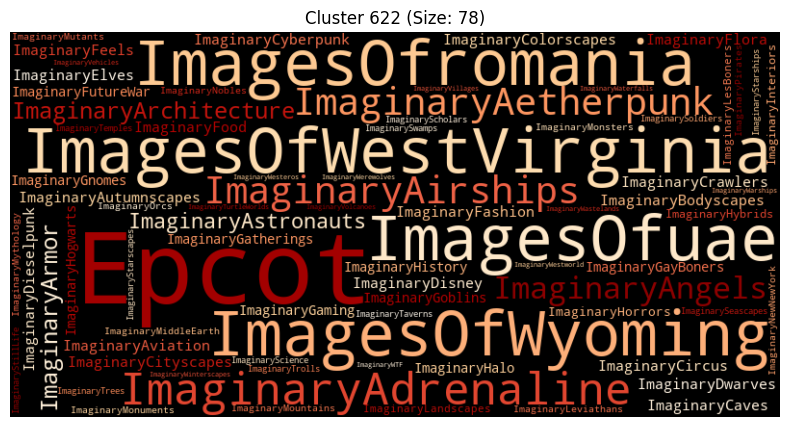

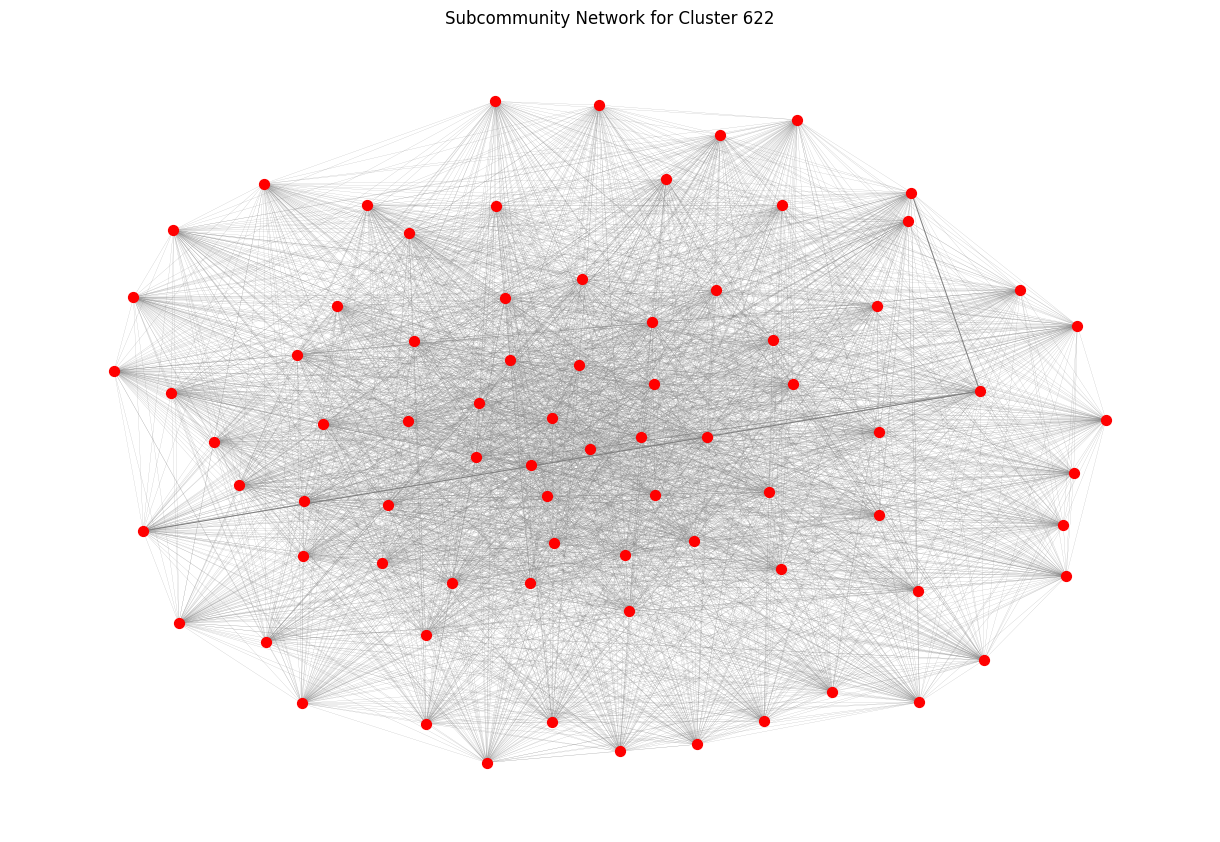

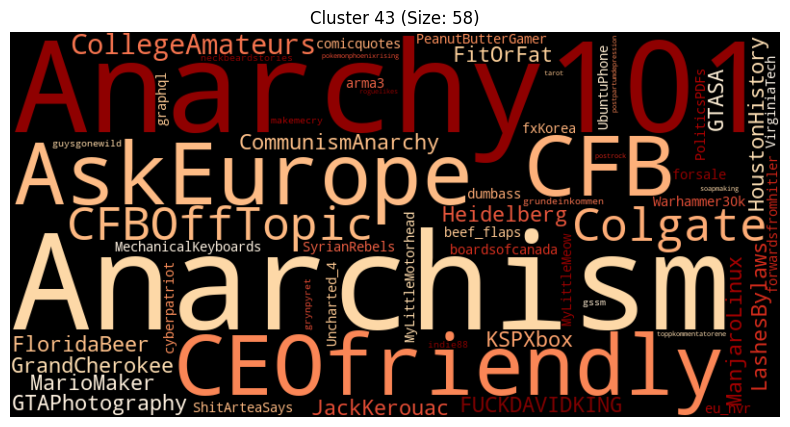

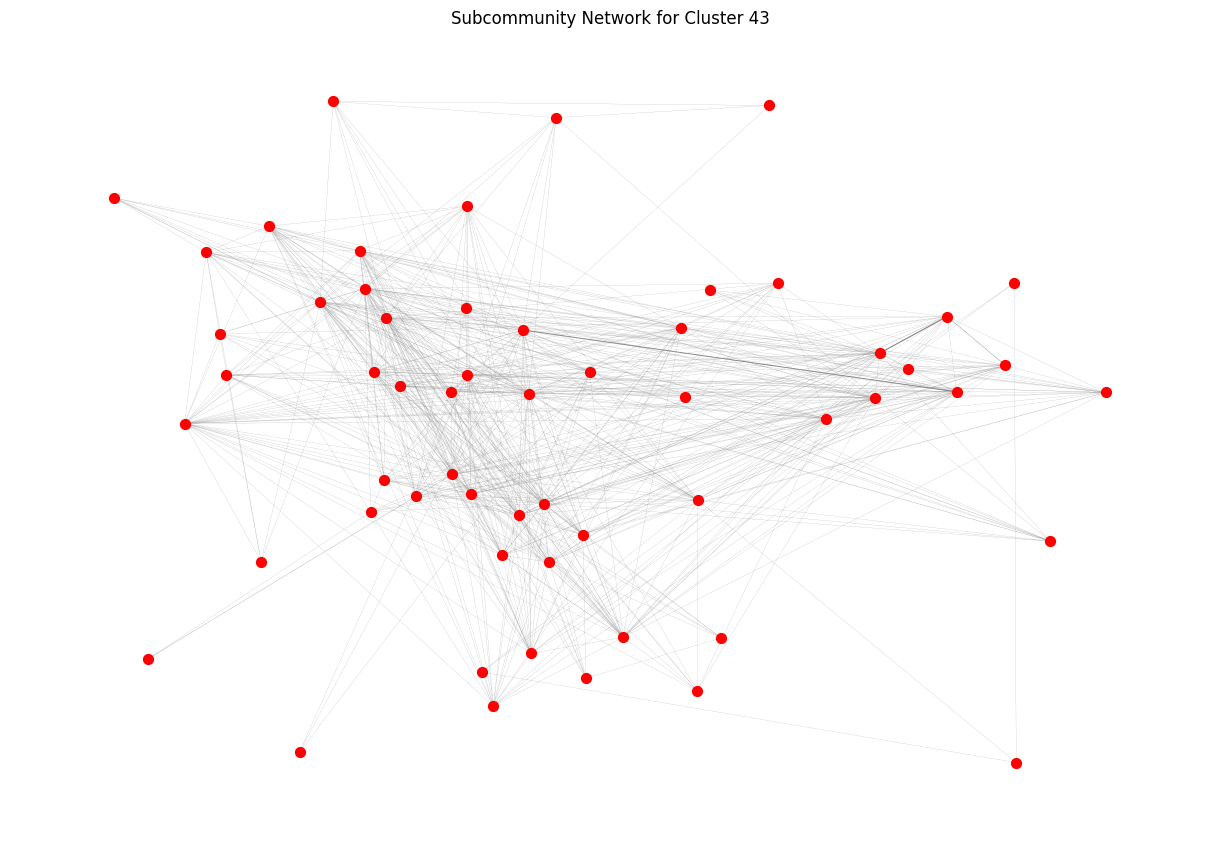

In [156]:
top_percent_index = int(len(groups) * 0.02)

random_indices = np.random.choice(np.arange(1, top_percent_index), size=2, replace=False)

for i in random_indices:
    subreddit_dict = groups.iloc[i]['Subreddits']
    cluster_nodes = list(subreddit_dict.keys())
    
    indices = [nodes_map[node] for node in cluster_nodes if node in nodes_map]
    subgraph = nx.from_numpy_array(A[np.ix_(indices, indices)])
    subgraph = nx.relabel_nodes(subgraph, {i: reverse_map[i] for i in indices})
    edge_weights = np.array([A[u, v] for u, v in subgraph.edges()])
    edge_weights = (edge_weights - edge_weights.min()) / (edge_weights.max() - edge_weights.min()) * 5
    
    wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='OrRd').generate_from_frequencies(subreddit_dict)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {groups.iloc[i]['Cluster']} (Size: {groups.iloc[i]['Cluster Size']})")
    plt.show()
    
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, seed=42)  # Positions for all nodes
    nx.draw(subgraph, pos, with_labels=False, node_color='red', edge_color='gray', width=np.log10(edge_weights+0.8), node_size=50, font_size=10)
    plt.title(f"Subcommunity Network for Cluster {groups.iloc[i]['Cluster']}")
    plt.show()
    
    print('\n\n')

Overall, there is some clear trends in the communities, but there are still many outlier subreddits that have little to no correlation on the surface. This could mean that we have a suboptimal value for $k$, or it could be the inherent randomness with human behavior. Since the computation of this algorithm is expensive, there might be simpler algorithms that can uncover the hidden communities in the data.

Another consideration is the type of data used to define the graph. Perhaps Subreddit joins might be a better indication of interest than commenting. This model takes into account every comment made and assigns weightage to each Subreddit based on this activity. However, this may not be the best heuristic.

The results of this model can be used to build unsupervised recommendation systems with the use of any complex neural networks, which could make it easy to compute, but it might oversimplify user interests.

## References

[1] Jianbo Shi and J. Malik, "Normalized cuts and image segmentation," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 22, no. 8, pp. 888-905, Aug. 2000, doi: 10.1109/34.868688.

[2] Xie, Yao, "Spectral Clustering." Class lecture, Computational Data Analytics, Georgia Institute of Technology, Atlanta, GA. August 21, 2024.